In [1]:
import bayesnewton
import jax
import objax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from convertbng.util import convert_bng, convert_lonlat
import time
from sklearn.model_selection import train_test_split
import datetime
import math   
from scipy.stats import beta
from jax import vmap



import cv2
import sys, os
sys.path.append('../Utils')
import model_utils as mutils
import kernels_definitions as kerns
%load_ext autoreload
%autoreload 2

/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
#DATA VARIABLES
SYSTEMS_NUM = 10
TIMESTEPS_NUM = 2000 
TRAIN_FRAC = 48
GRID_PIXELS = 20

#OPTIMISATION VARIABLES
LR_ADAM = 0.05
LR_NEWTON = 0.5
ITERS = 10

#GP Variables
VAR_Y = 0.5
VAR_F = 0.5
LEN_TIME = 6  # step size = 1 (hour)
LEN_SPACE = 1

#Want to use a sparse approximation
SPARSE = True
#Should we optimise the inducing points
OPT_Z = False  # will be set to False if SPARSE=SPARSE

#use a mean field approximation?
MEAN_FIELD = False
MINI_BATCH_SIZE = None #none if you don't want them

TEST_STATIONS = 10

In [3]:
data =  pd.read_csv('../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime')
uk_pv = pd.read_csv('../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')
#data_multiple.plot(legend=False)
lats = dict(uk_pv.set_index('ss_id')['latitude_noisy'])
longs = dict(uk_pv.set_index('ss_id')['longitude_noisy'])
data_multiple = data.iloc[:, :SYSTEMS_NUM][:TIMESTEPS_NUM].reset_index()
stacked = mutils.stack_dataframe(data_multiple, lats, longs)
capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.columns)].set_index('ss_id_string')['kwp'].values * 1000


In [4]:
X = np.array(stacked[['epoch', 'longitude', 'latitude']])
Y = np.array(stacked[['PV']])

# convert to easting and northings
british_national_grid_coords = convert_bng(X[:, 1], X[:, 2])
X = np.vstack([X[:, 0],
              np.array(british_national_grid_coords[0]),
              np.array(british_national_grid_coords[1])]).T

#Create a space-time grid from X and Y
t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)


/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Text(0.5, 1.0, 'Grid of initial inducing points')

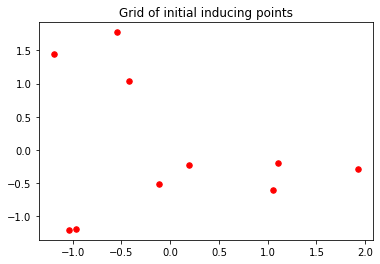

In [5]:
#train test split for 3 dimensional data
t_train, t_test, R_train, R_test, Y_train, Y_test = mutils.train_split_3d(t, R, Y, train_frac = TRAIN_FRAC, split_type = 'Cutoff')

#get the mask of the test points
test_mask = np.in1d(t.squeeze(), t_test.squeeze())

#Scale the data
scaled_values = mutils.scale_2d_train_test_data(R, Y, R_train, R_test, Y_train, Y_test )
R_scaler, R_scaled, R_train_scaled, R_test_scaled, _, _, _, _ = scaled_values

#here get a list of scaled coordinates (frozen because at some point in time)
R_scaled_frozen = R_scaled[0]

# #Create a grid to perform prediction/interpolation on
r1, r2, Rplot = mutils.create_grid_from_coords(R = R_scaled_frozen, t = t, R_scaler = R_scaler, N_pixels = GRID_PIXELS)

z = R_scaled[2, ...] 

    
plt.scatter(*zip(*z), marker='o', s=30, color='red')
plt.title('Grid of initial inducing points')


In [6]:
# kern = kerns.get_SpatioTemporal_combined(variance=VAR_F,
#                                            lengthscale_time=LEN_TIME,
#                                            lengthscale_space=[LEN_SPACE, LEN_SPACE],
#                                            z=z,
#                                            sparse=SPARSE,
#                                            opt_z=OPT_Z,
#                                            matern_order = '32',
#                                            conditional='Full')

kern = kerns.get_periodic_kernel(variance=VAR_F,
                                               lengthscale_time=LEN_TIME,
                                               lengthscale_space=[LEN_SPACE, LEN_SPACE], #[LEN_SPACE, LEN_SPACE, LEN_ALTITUDE]
                                               z=z,
                                               sparse=SPARSE,
                                               opt_z=OPT_Z,
                                               conditional='FIC',
                                                order=2)

changed the order matrix


In [7]:
if MEAN_FIELD:
    lik = bayesnewton.likelihoods.Beta(scale = 30, fix_scale=False, link='probit')
    model = bayesnewton.models.MarkovVariationalMeanFieldGP(kernel=kern, likelihood=lik, X=t_train, R=R_train_scaled, Y=Y_train, parallel = True)
else:    
    lik = bayesnewton.likelihoods.Beta(scale = 30, fix_scale=False, link='probit')
    model = bayesnewton.models.MarkovVariationalGP(kernel = kern, likelihood = lik, X=t_train, Y=Y_train, R=R_train_scaled)
    
opt_hypers = objax.optimizer.Adam(model.vars())
energy = objax.GradValues(model.energy, model.vars())

@objax.Function.with_vars(model.vars() + opt_hypers.vars())
def train_op(batch_ind = None):
    model.inference(lr=LR_NEWTON, batch_ind = batch_ind)  #perform inference and update variational params
    dE, E = energy()  # compute energy and its gradients w.r.t. hypers
    opt_hypers(LR_ADAM, dE)
    return E

# train_op = objax.Jit(train_op)


/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5373: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


In [8]:
if MINI_BATCH_SIZE == None:
    number_of_minibatches = 1
    mini_batches_indices = [None] * number_of_minibatches
else:
    number_of_minibatches = int(len(t_train) / MINI_BATCH_SIZE)
    idx_set = np.arange(len(t_train))
    np.random.shuffle(idx_set)
    mini_batches_indices = np.array_split(idx_set, number_of_minibatches)

In [9]:
t0 = time.time()
for i in range(1, ITERS + 1):
    for mini_batch in range(number_of_minibatches):
        if number_of_minibatches > 1:
            print(f'Doing minibatch {mini_batch}')
        loss = train_op(mini_batches_indices[mini_batch])
    print('iter %2d, energy: %1.4f' % (i, loss[0]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))
avg_time_taken = (t1-t0)/ITERS


iter  1, energy: 1871.1690
iter  2, energy: -11813.6109
iter  3, energy: -21618.5067
iter  4, energy: -32410.0294
iter  5, energy: -44565.5102
iter  6, energy: -54186.2488
iter  7, energy: -57117.8850
iter  8, energy: -58044.5861
iter  9, energy: -58155.8531
iter 10, energy: -58234.0718
optimisation time: 153.33 secs


In [10]:
# calculate posterior predictive distribution via filtering and smoothing at train & test locations:
t0 = time.time()
print('calculating the posterior predictive distribution ...')
posterior_mean, posterior_var = model.predict_y(X=t, R=Rplot)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))

t2 = time.time()
print('calculating the negative log predictive density ...')
nlpd = model.negative_log_predictive_density(X=t_test, R=R_test_scaled, Y=Y_test)
t3 = time.time()
print('nlpd calculation time: %2.2f secs' % (t3-t2))
print('nlpd: %2.3f' % nlpd)


calculating the posterior predictive distribution ...
Inside the temporal conditional
prediction time: 38.32 secs
calculating the negative log predictive density ...
Inside the temporal conditional
nlpd calculation time: 5.41 secs
nlpd: -2.280


In [11]:
z_opt = model.kernel.z.value
# mu = Y_scaler.inverse_transform(posterior_mean.flatten()[:, np.newaxis]).reshape(-1, GRID_PIXELS, GRID_PIXELS)
mu = posterior_mean.reshape(TIMESTEPS_NUM, GRID_PIXELS, GRID_PIXELS)
Y = Y[:,:,0]

#get lat-lon coordinates
grid_coord = R_scaler.inverse_transform(np.array(np.c_[r1,r2]))
longitude_grid, latitude_grid =  convert_lonlat(grid_coord[:, 0], grid_coord[:, 1])
longitude_sys_train, latitude_sys_train = convert_lonlat(R_train[:,:,0][0], R_train[:,:,1][0])
longitude_z, latitude_z = convert_lonlat(R_scaler.inverse_transform(z_opt)[:,0], R_scaler.inverse_transform(z_opt)[:,1])


plotting ...


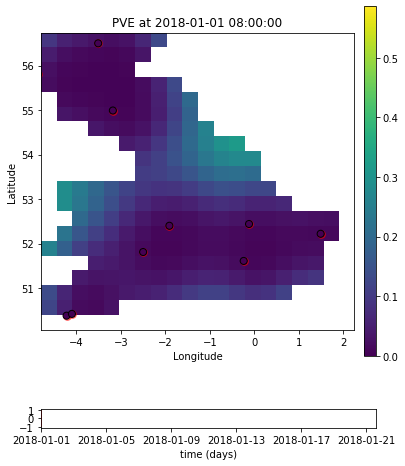

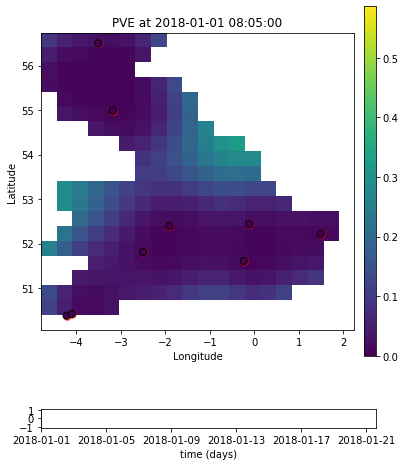

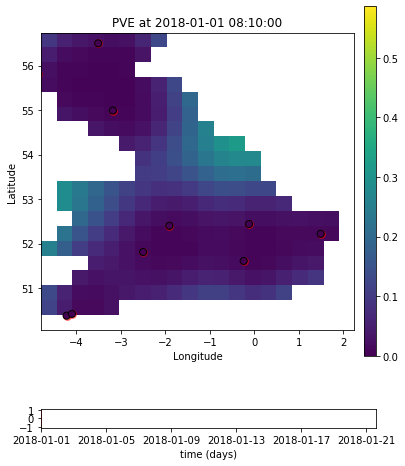

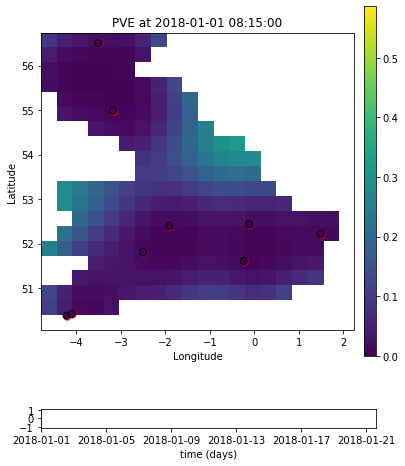

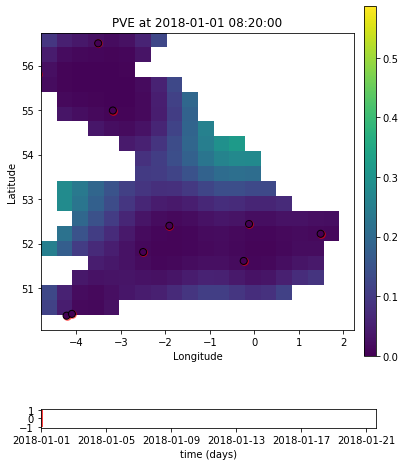

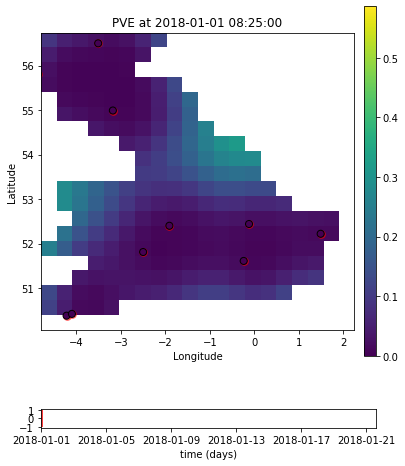

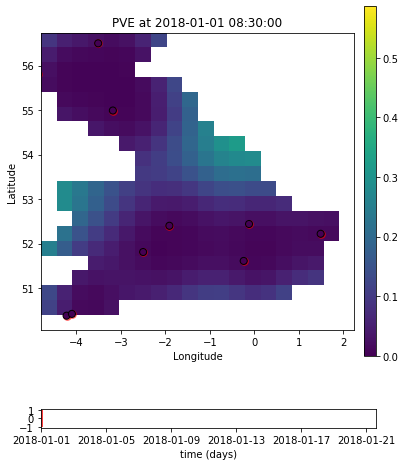

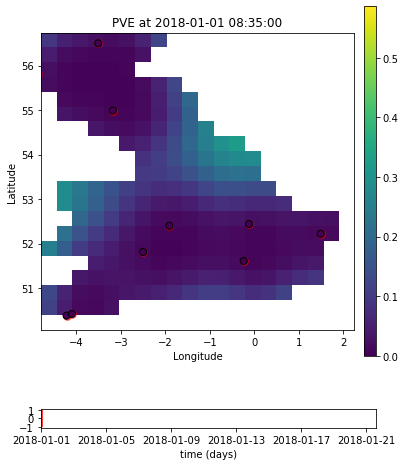

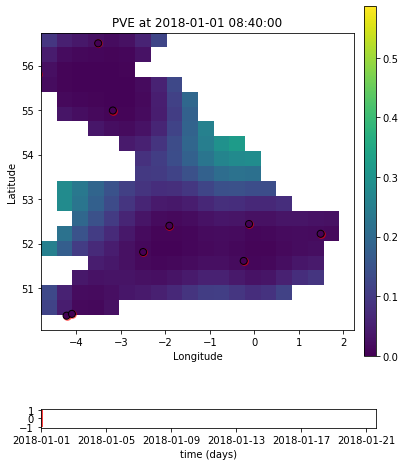

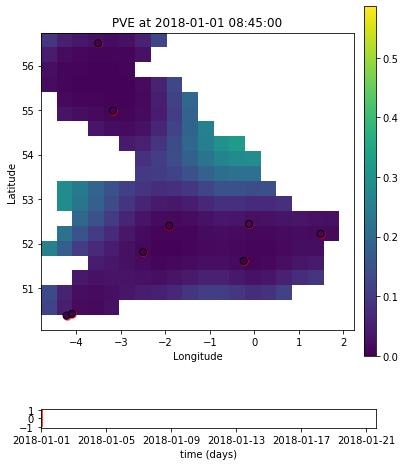

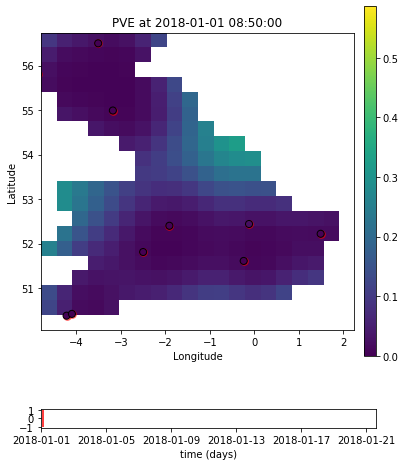

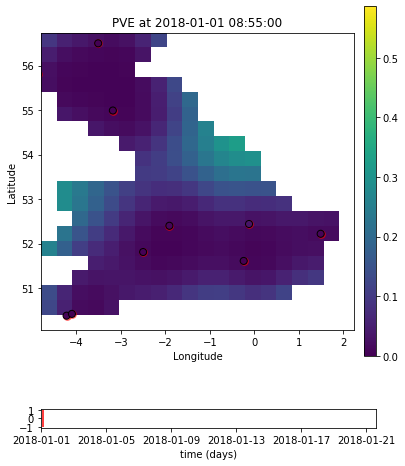

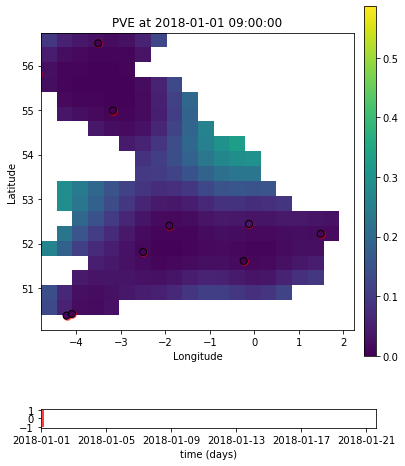

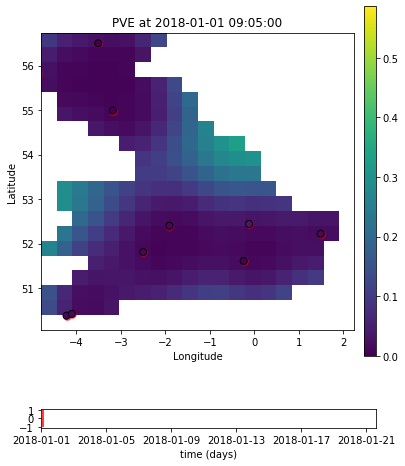

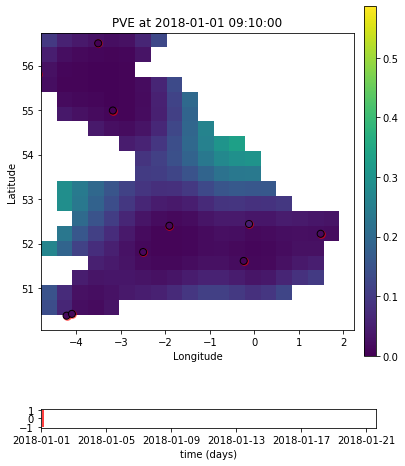

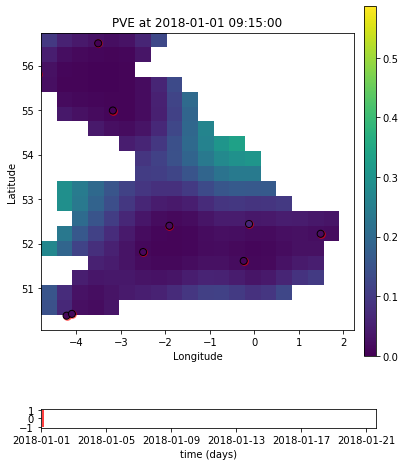

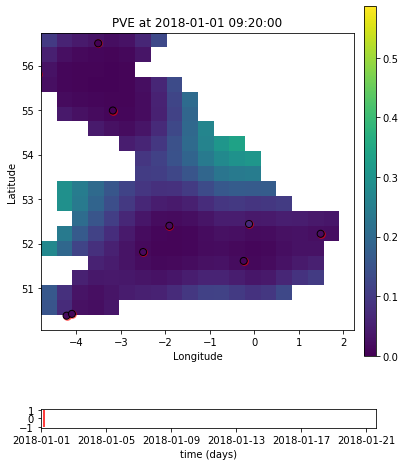

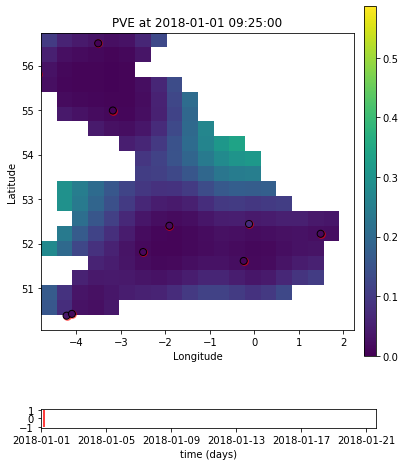

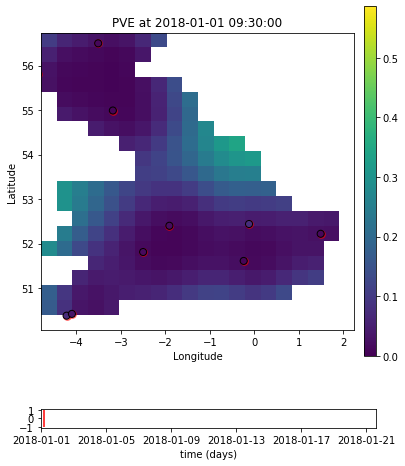

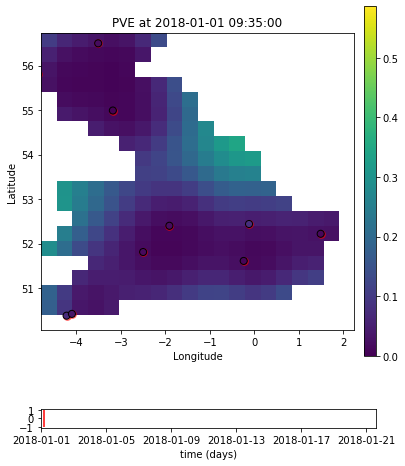

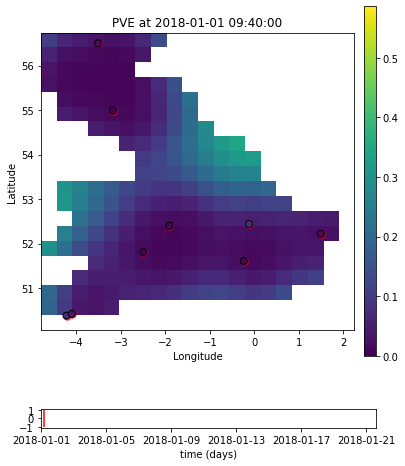

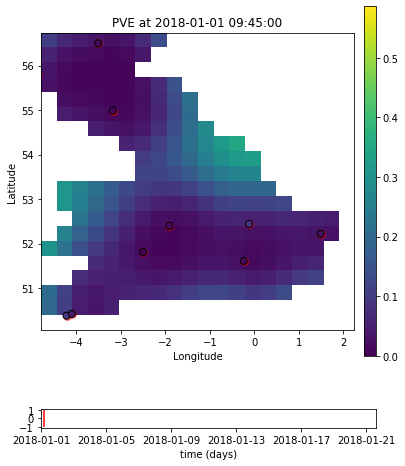

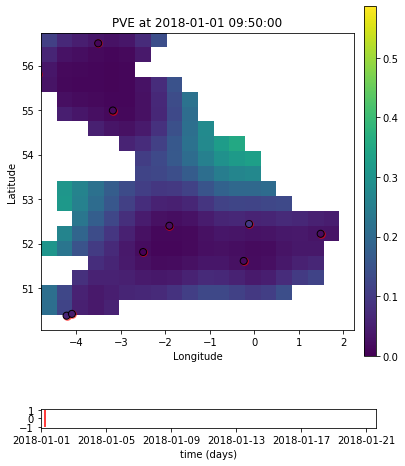

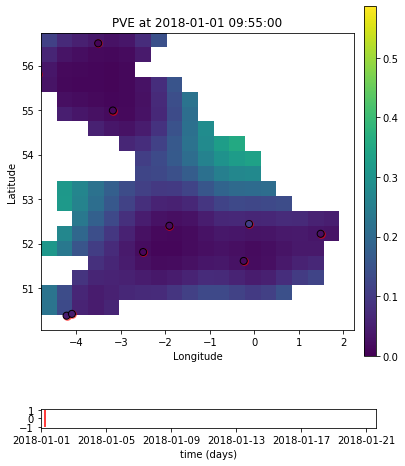

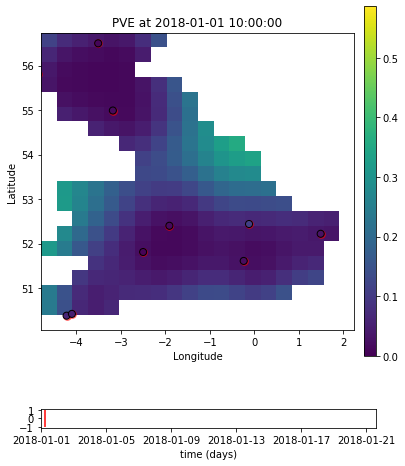

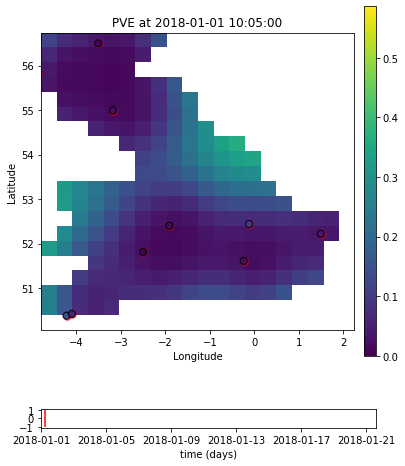

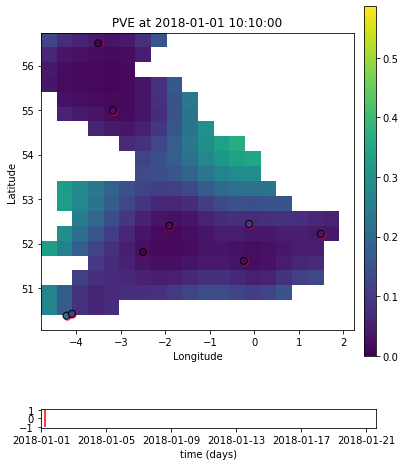

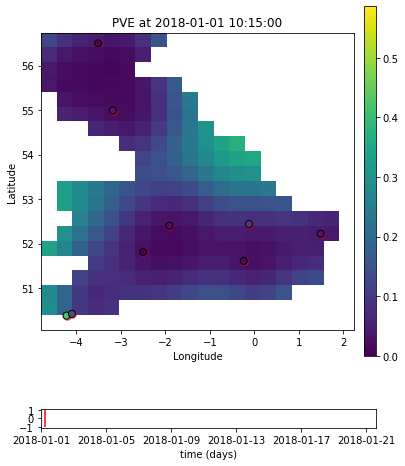

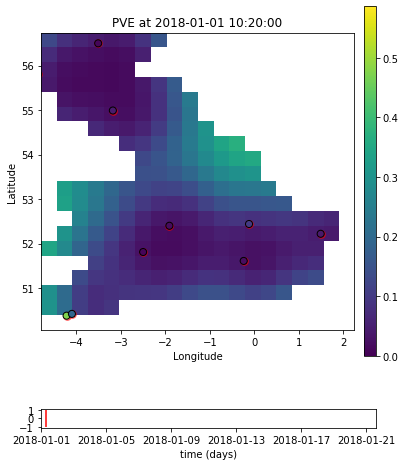

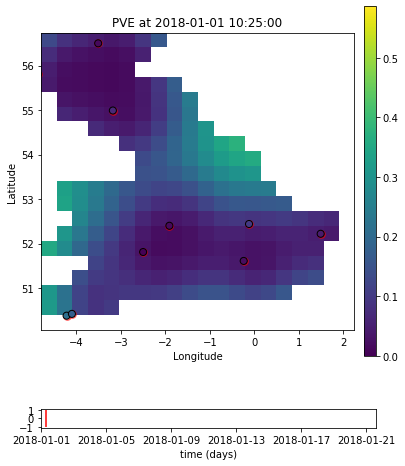

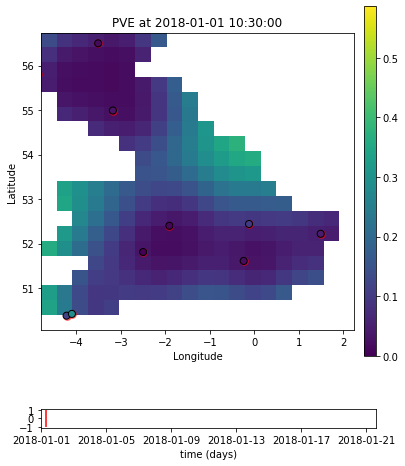

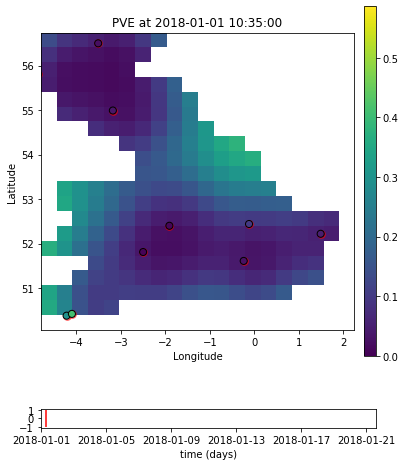

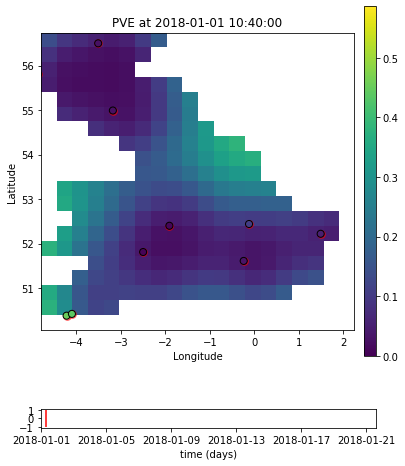

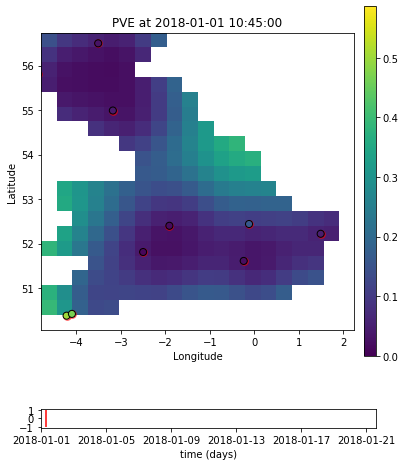

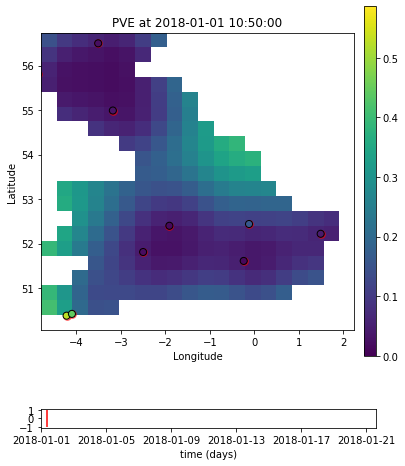

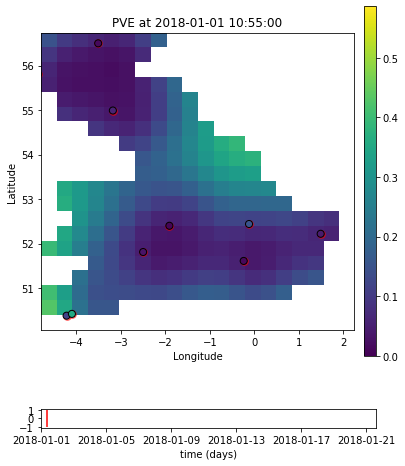

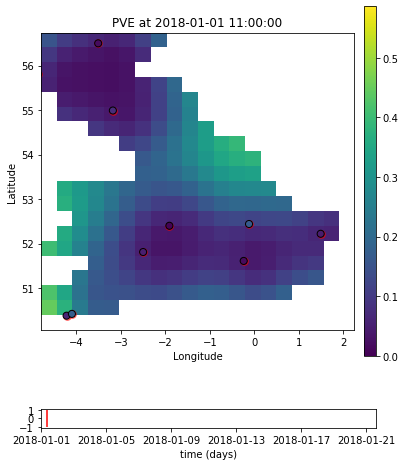

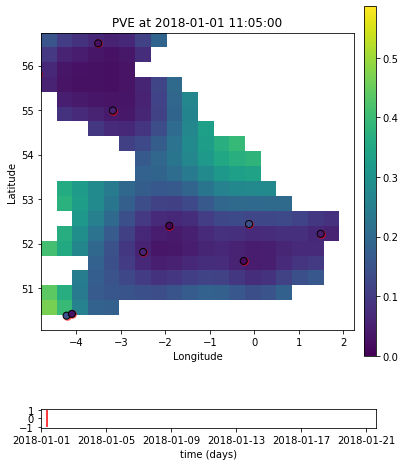

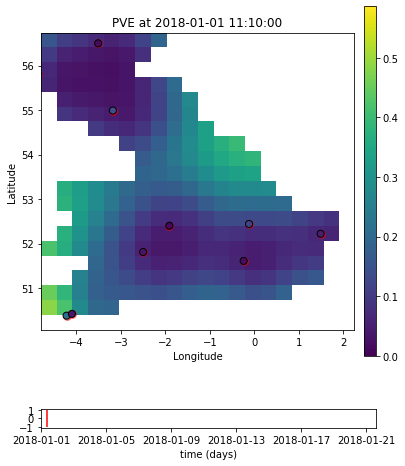

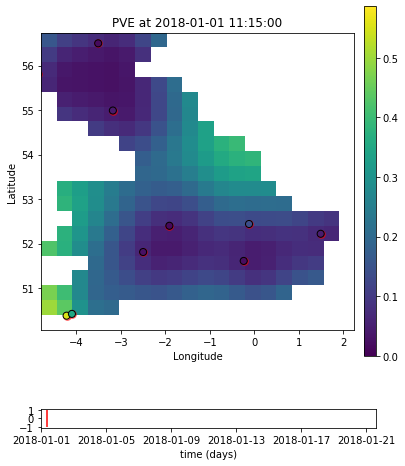

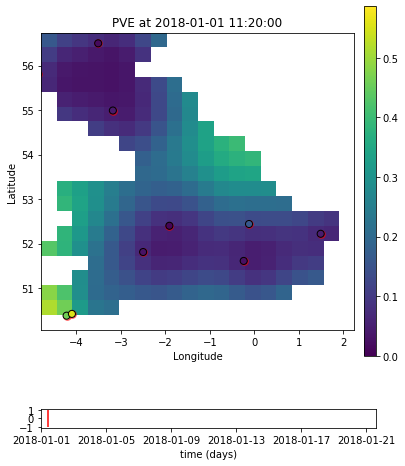

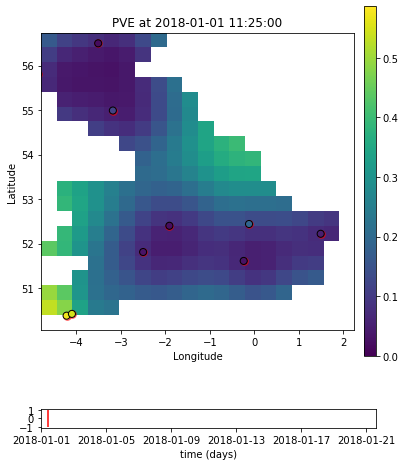

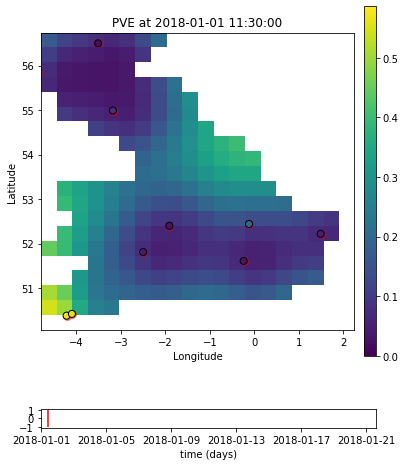

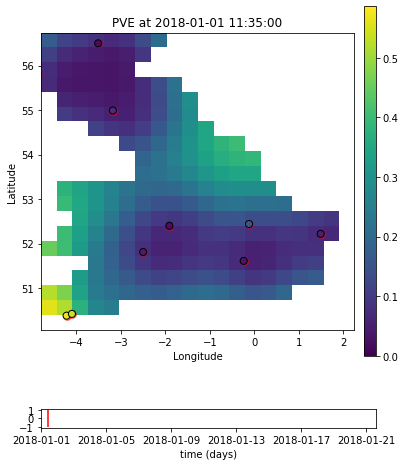

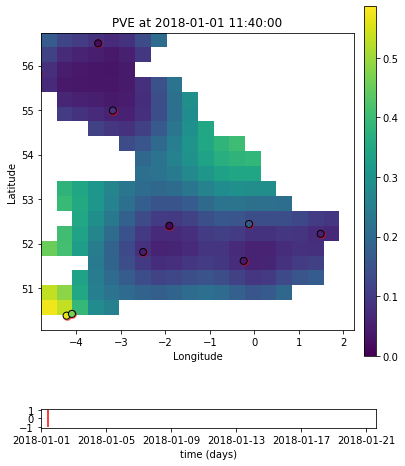

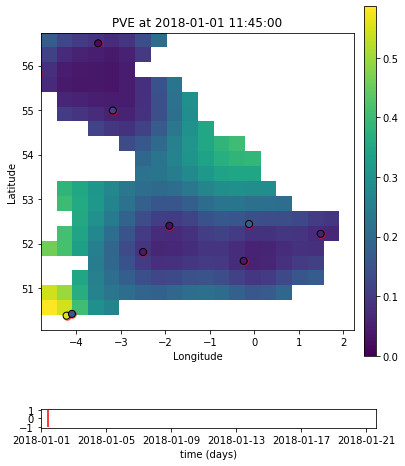

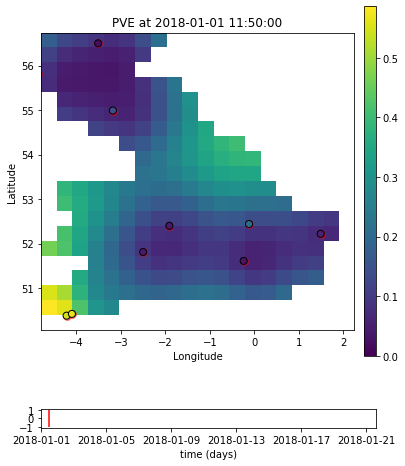

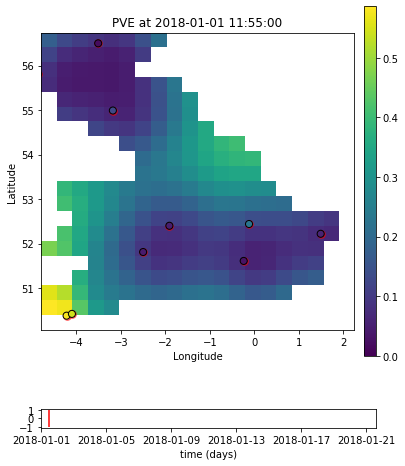

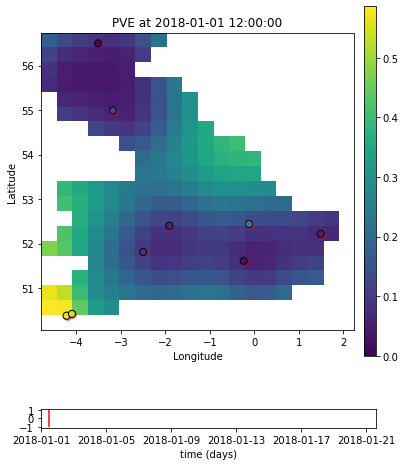

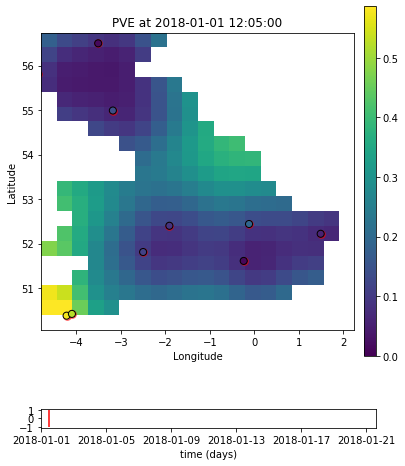

In [12]:
save_result = False
# del model, kern, Rplot  # , var

print('plotting ...')
cmap = cm.viridis
vmin = np.nanpercentile(Y, 1)
vmax = np.nanpercentile(Y, 99)
#get the labels for the dates
dates = pd.to_datetime(data_multiple.datetime).dt.date
days_index = max(97, int(((len(t) / 5) // 97) * 97)) #number of time intervals to match 5 beginnings of days

for time_step in range(t.shape[0])[:50]:
    f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [20, 1]})
    f.set_figheight(8)
    # f.set_figwidth(8)
    im = a0.imshow(mu[time_step], cmap=cmap, vmin=vmin, vmax=vmax,
                   extent=[longitude_grid[0], longitude_grid[-1], latitude_grid[0], latitude_grid[-1]], origin='lower')
    if SPARSE:
        a0.scatter(longitude_z, latitude_z, c='r', s=60, alpha=0.5)  # plot inducing inputs
    a0.scatter(longitude_sys_train, latitude_sys_train, cmap=cmap, vmin=vmin, vmax=vmax,
               c=np.squeeze(Y[time_step]), s=50, edgecolors='black')
    plt.colorbar(im, fraction=0.0348, pad=0.03, aspect=30, ax=a0)
    
    a0.set_xlim(longitude_grid[0], longitude_grid[-1])
    a0.set_ylim(latitude_grid[0], latitude_grid[-1])
    a0.set_title(f'PVE at {data_multiple.datetime.unique()[time_step]}')
    a0.set_ylabel('Latitude')
    a0.set_xlabel('Longitude')
    a1.vlines(t[time_step].item(), -1, 1, 'r')
    a1.set_xlabel('time (days)')
    a1.set_xlim(t[0], t[-1])
    
    a1.set_xticks(np.asarray(t[1:-1:days_index ][:,0].tolist()), 
                  labels = dates[0:-1:days_index].values,
                     fontsize = 10)
    plt.show()
    plt.close(f)

Inside the temporal conditional
The MAE is 0.053
The train MAE is 0.055
The average 2 hours test MAE is 0.012955170452801321


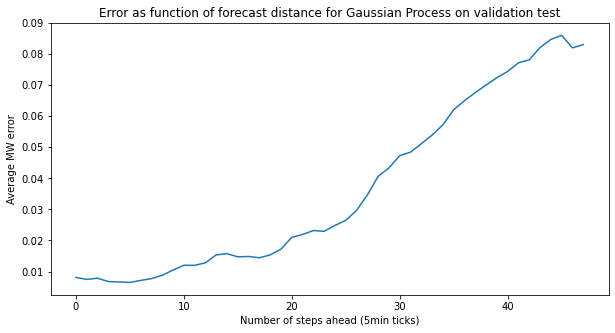

In [13]:
#GET THE SYSTEM SPECIFIC PREDICTIONS (NOT THE TOTAL INTERPOLATION)
len_samples = len(t_test) + 500
test_mask_shortened = test_mask[-len_samples:]

f_mean, f_var = model.predict(X=t[-len_samples:], R=R_scaled[-len_samples:])

#GET THE Y PREDICTIONS FROM THE F VALUES
f_mean = f_mean.reshape(f_mean.shape[0], -1, 1)
f_var = f_var.reshape(f_var.shape[0], -1, 1)

mean_y, var_y = vmap(model.likelihood.predict, (0, 0, None))(f_mean, f_var, None)
posterior_mean_ts, posterior_var_ts = np.squeeze(mean_y), np.squeeze(var_y)# posterior_mean_rescaled = Y_scaler.inverse_transform(posterior_mean_ts)

#GET THE PREDICTION INTERVALS AND CALCULATE ERRORS

posterior_pos_twostd_rescaled = posterior_mean_ts + 1.96 * np.sqrt(posterior_var_ts)
posterior_neg_twostd_rescaled = posterior_mean_ts - 1.96 * np.sqrt(posterior_var_ts)

rescaled_Y = (Y ) #* capacities)
rescaled_posterior = posterior_mean_ts#) #* capacities

#adjust this for the correct quantities
mae = np.nanmean(abs(np.squeeze(rescaled_Y[-len_samples:]) - np.squeeze(rescaled_posterior)))
print(f'The MAE is {mae.round(3)}')

mae_train = np.nanmean(abs(np.squeeze(rescaled_Y[-len_samples:][~test_mask_shortened]) - np.squeeze(rescaled_posterior[~test_mask_shortened])))
print(f'The train MAE is {mae_train.round(3)}')

mae_test = np.nanmean(abs(np.squeeze(rescaled_Y[-len_samples:][test_mask_shortened]) - np.squeeze(rescaled_posterior[test_mask_shortened])), axis=1)
plt.figure(figsize=(10,5))
plt.plot(mae_test)
plt.title('Error as function of forecast distance for Gaussian Process on validation test')
plt.xlabel('Number of steps ahead (5min ticks)')
plt.ylabel('Average MW error')

print(f'The average 2 hours test MAE is {mae_test[:24].mean()}')


In [23]:
#SAMPLE THE UNCERTAINTY BOUNDS
N_samples = 1000
#Sample values of f at each point
sampled_f = np.random.normal(f_mean[:,:,0], f_var[:,:,0], size=(N_samples, f_var.shape[0], f_var.shape[1]))

alpha_sampled = model.likelihood.link_fn(sampled_f) * model.likelihood.scale
beta_sampled = model.likelihood.scale - alpha_sampled

beta_samples = np.random.beta(alpha_sampled, beta_sampled, size=(alpha_sampled.shape[0], alpha_sampled.shape[1], alpha_sampled.shape[2]))
lower_bounds_beta_MC = np.quantile(beta_samples, 0.025, axis=0)
upper_bounds_beta_MC = np.quantile(beta_samples, 0.975, axis=0)


The total NLL is -885.1207054373092


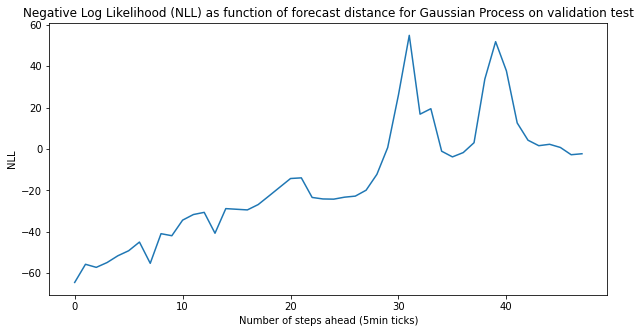

In [83]:
observed_repeated = np.repeat(rescaled_Y[-len_samples:][test_mask_shortened][np.newaxis, :, :], N_samples, axis=0)
observed_repeated = observed_repeated.at[observed_repeated==0].set(10e-6)
#NOTE -> I NEED TO AVERAGE OVER THE MC SAMPLES FOR THE SPECIFIC POINT, 
#BUT THEN I NEED TO MULTIPLY OVER THE NLL FOR DIFFERENT POINTS
likelihoods = beta.pdf(observed_repeated,  alpha_sampled[:, test_mask_shortened], beta_sampled[:, test_mask_shortened])
NNL_hsteps =   -np.sum(np.log(likelihoods.mean(axis=0)), axis=1)[:, np.newaxis]

plt.figure(figsize=(10,5))
plt.plot(NNL_hsteps)
plt.title('Negative Log Likelihood (NLL) as function of forecast distance for Gaussian Process on validation test')
plt.xlabel('Number of steps ahead (5min ticks)')
plt.ylabel('NLL')

print(f'The total NLL is {NNL_hsteps[:24].sum()}')



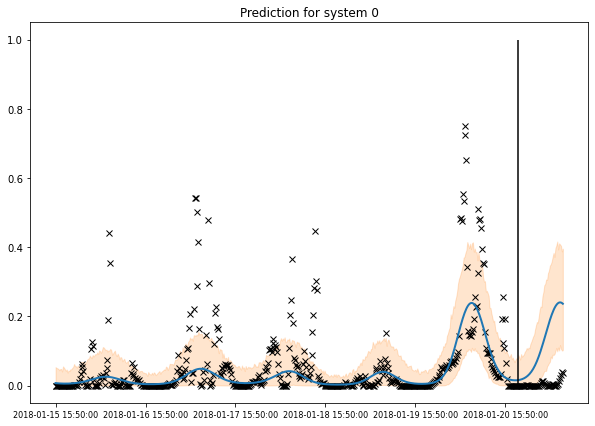

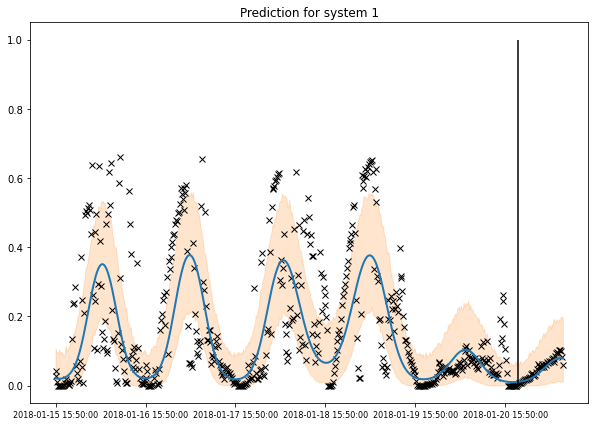

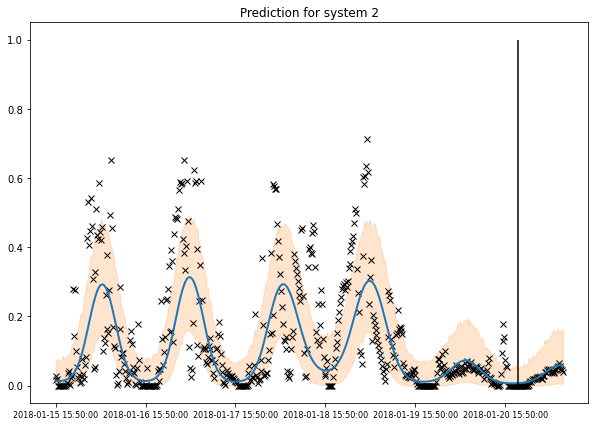

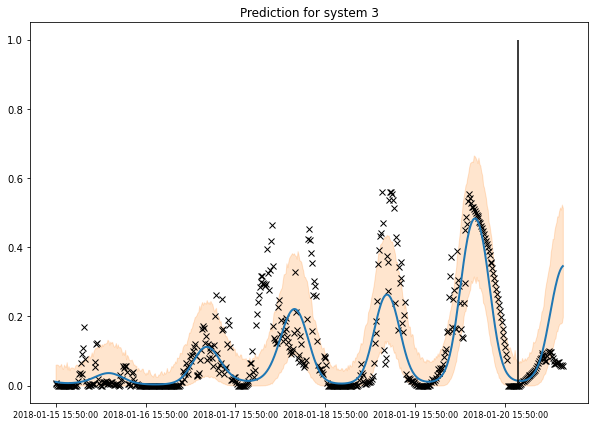

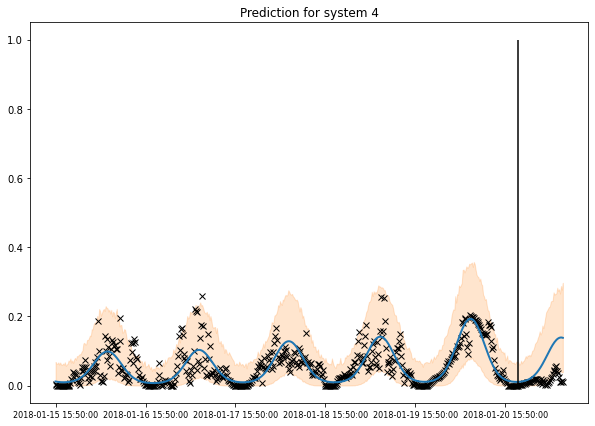

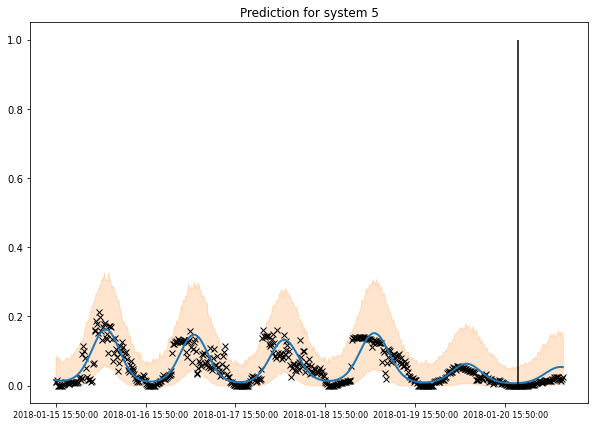

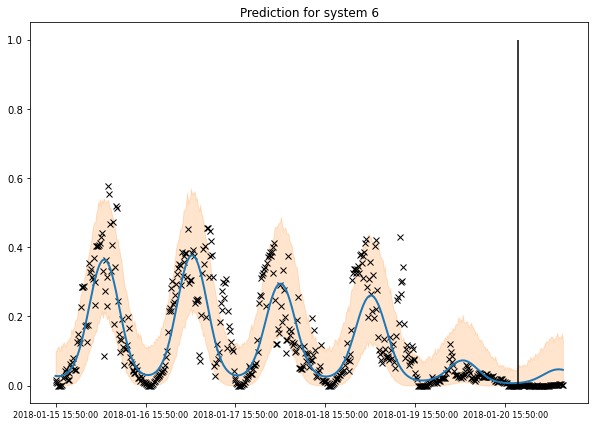

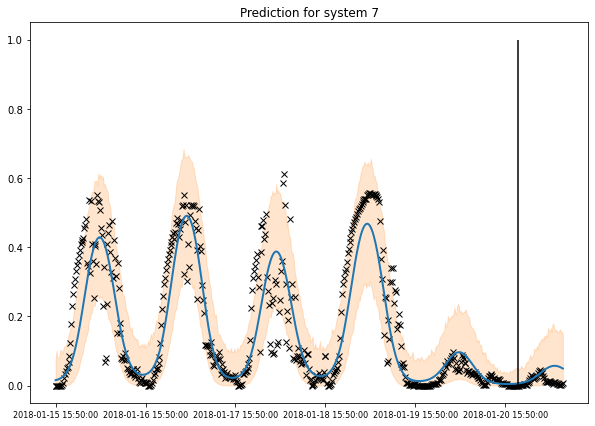

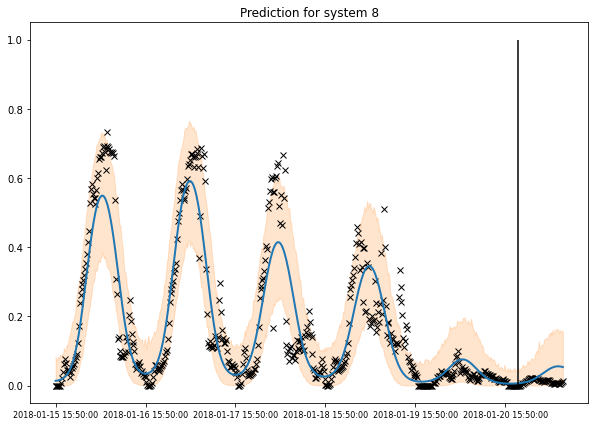

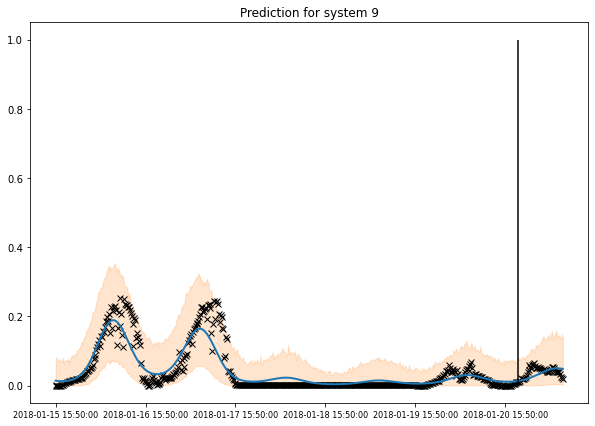

In [25]:
days_index = max(97, int(((len_samples / 3) // 97) * 97)) #number of time intervals to match 5 beginnings of days

for i in range(SYSTEMS_NUM):
    plt.figure(figsize=(10,7))
    plt.title(f'Prediction for system {i}')
    plt.plot(np.arange(len(Y))[-len_samples:], Y[:,i][-len_samples:], "xk")
    plt.plot(np.arange(len(Y))[-len_samples:], posterior_mean_ts[:,i][-len_samples:], c="C0", lw=2, zorder=2)
#     plt.plot(np.arange(len(Y))[-len_samples:], R[-len_samples:, i, 2], 'green', alpha = 0.1)
    plt.vlines(t_train[-1], 0, 1, colors='k')

    plt.fill_between(
        np.arange(len(Y))[-len_samples:],
        lower_bounds_beta_MC[:,i],
        upper_bounds_beta_MC[:,i],
        color="C1",
        alpha=0.2)
    
    plt.xticks(ticks = np.arange(len(Y))[-len_samples:-1:days_index], labels = data_multiple.datetime[-len_samples:-1:days_index].values, size=8)
    

## Get the Uncertainty intervals

There are 3 ways to get quantiles:

- Using the mean_f and the inverse CDF 
- Using the mean_f and sampling from Beta(alpha, beta / f)
- Sampling directly from f* ~ Gaussian(f) and sampling again from Beta(alpha, beta / f*)


### First Method

In [ ]:
#Get the mean and var of f at each datapoint
f_mean, f_var = model.predict(X=t, R=R_scaled)

#Sample values of f at each point
sampled_f = np.random.normal(f_mean, f_var, size=(500, f_var.shape[0], f_var.shape[1]))

#get 
alpha_laplace = model.likelihood.link_fn(f_mean) * model.likelihood.scale
beta_laplace = model.likelihood.scale - alpha_laplace

lower_bounds_beta_laplace_cdf = beta.ppf(0.025, alpha_laplace, beta_laplace)
upper_bounds_beta_laplace_cdf = beta.ppf(0.975, alpha_laplace, beta_laplace)


### Second Method

In [ ]:
sampled_beta_laplace = np.random.beta(alpha_laplace, beta_laplace, size=(1000, alpha_laplace.shape[0], alpha_laplace.shape[1]))
lower_bounds_beta_laplace_sampled = np.quantile(sampled_beta_laplace, 0.025, axis=0)
upper_bounds_beta_laplace_sampled  = np.quantile(sampled_beta_laplace, 0.975, axis=0)


### Third Method

In [ ]:
alpha_sampled = model.likelihood.link_fn(sampled_f) * model.likelihood.scale
beta_sampled = model.likelihood.scale - alpha_sampled

beta_samples = np.random.beta(alpha_sampled, beta_sampled, size=(alpha_sampled.shape[0], alpha_sampled.shape[1], alpha_sampled.shape[2]))
lower_bounds_beta_MC = np.quantile(beta_samples, 0.025, axis=0)
upper_bounds_beta_MC = np.quantile(beta_samples, 0.975, axis=0)


### Comparison

In [ ]:
plt.plot(lower_bounds_beta_laplace_sampled[:,5]); 
plt.plot(lower_bounds_beta_laplace_cdf[:,5]);
plt.plot(lower_bounds_beta_MC[:,5]); 

plt.plot(upper_bounds_beta_laplace_sampled[:,5]); 
plt.plot(upper_bounds_beta_laplace_cdf[:,5]);
plt.plot(upper_bounds_beta_MC[:,5]); 

plt.plot(np.arange(len(Y)), posterior_mean_ts[:,5], c="k", lw=2, zorder=2)

# plt.xlim(0,300)
# plt.ylim(0, 0.10)

In [ ]:
for i in range(SYSTEMS_NUM):
    plt.figure(figsize=(10,7))
    plt.title(f'Prediction for system {i}')
    plt.plot(np.arange(len(Y)), Y[:,i], "xk")
    plt.plot(np.arange(len(Y)), posterior_mean_ts[:,i], c="C0", lw=2, zorder=2)
#     plt.plot(np.arange(len(Y)), post_samp[:,:, i].T)

    plt.fill_between(
        np.arange(len(Y)),
        lower_bounds_beta_laplace_sampled[:,i],
        upper_bounds_beta_laplace_sampled[:,i],
        color="C1",
        alpha=0.5)
    
    plt.fill_between(
        np.arange(len(Y)),
        lower_bounds_beta_laplace_cdf[:,i],
        upper_bounds_beta_laplace_cdf[:,i],
        color="red",
        alpha=0.2)
    
    plt.fill_between(
        np.arange(len(Y)),
        lower_bounds_beta_MC[:,i],
        upper_bounds_beta_MC[:,i],
        color="blue",
        alpha=0.2)
    
    plt.xticks(ticks = np.arange(len(Y))[0:-1:days_index], labels = data_multiple.datetime[0:-1:days_index].values, size=8)
    

So we can see that as expected the red uncertainty (the one using the inverse CDF) is much smaller, since it does not take into account the uncertainty in the latent $f$

## Predict on Unseen Locations

In [ ]:
data_unseen = data.iloc[:, SYSTEMS_NUM:SYSTEMS_NUM+TEST_STATIONS][:TIMESTEPS_NUM].reset_index()
capacities_unseen = uk_pv[uk_pv.ss_id_string.isin(data_unseen.columns)].set_index('ss_id_string')['kwp'].values * 1000
stacked_unseen = mutils.stack_dataframe(data_unseen, lats, longs)

X_unseen = np.array(stacked_unseen[['epoch', 'longitude', 'latitude']])
Y_unseen = np.array(stacked_unseen[['PV']])

# convert to easting and northings
british_national_grid_coords_unseen = convert_bng(X_unseen[:, 1], X_unseen[:, 2])
X_unseen = np.vstack([X_unseen[:, 0],
              np.array(british_national_grid_coords_unseen[0]),
              np.array(british_national_grid_coords_unseen[1])]).T

#Create a space-time grid from X and Y
t, R_unseen, Y_unseen = bayesnewton.utils.create_spatiotemporal_grid(X_unseen, Y_unseen)
R_unseen_scaled = np.tile(R_scaler.transform(R_unseen[0]), (R_unseen.shape[0],1, 1))


In [ ]:
############################FIRST METHOD 

#Get the mean and var of f at each datapoint
posterior_mean_unseen, posterior_var_unseen = model.predict_y(X=t, R=R_unseen_scaled)
f_mean_unseen, f_var_unseen = model.predict(X=t, R=R_unseen_scaled)

#Sample values of f at each point
sampled_f_unseen = np.random.normal(f_mean_unseen, f_var_unseen, size=(N_SAMPLES_UNSEEN, f_var_unseen.shape[0], f_var_unseen.shape[1]))

unseen_alpha_laplace = model.likelihood.link_fn(f_mean_unseen) * model.likelihood.scale
unseen_beta_laplace = model.likelihood.scale - unseen_alpha_laplace

unseen_lower_bounds_beta_laplace_cdf = beta.ppf(0.025, unseen_alpha_laplace, unseen_beta_laplace)
unseen_upper_bounds_beta_laplace_cdf = beta.ppf(0.975, unseen_alpha_laplace, unseen_beta_laplace)

############################SECOND METHOD 

unseen_sampled_beta_laplace = np.random.beta(unseen_alpha_laplace, unseen_beta_laplace, size=(1000, unseen_alpha_laplace.shape[0], unseen_alpha_laplace.shape[1]))
unseen_lower_bounds_beta_laplace_sampled = np.quantile(unseen_sampled_beta_laplace, 0.025, axis=0)
unseen_upper_bounds_beta_laplace_sampled  = np.quantile(unseen_sampled_beta_laplace, 0.975, axis=0)

############################THIRD METHOD 

unseen_alpha_sampled = model.likelihood.link_fn(sampled_f_unseen) * model.likelihood.scale
unseen_beta_sampled = model.likelihood.scale - unseen_alpha_sampled

unseen_beta_samples = np.random.beta(unseen_alpha_sampled, unseen_beta_sampled, size=(unseen_alpha_sampled.shape[0], unseen_alpha_sampled.shape[1], unseen_alpha_sampled.shape[2]))
unseen_lower_bounds_beta_MC = np.quantile(unseen_beta_samples, 0.025, axis=0)
unseen_upper_bounds_beta_MC = np.quantile(unseen_beta_samples, 0.975, axis=0)




In [ ]:
for i in range(SYSTEMS_NUM):
    plt.figure(figsize=(10,7))
    plt.title(f'Prediction for system {i}')
    plt.plot(np.arange(len(Y)), Y_unseen[:,i], "xk")
    plt.plot(np.arange(len(Y)), posterior_mean_unseen[:,i], c="C0", lw=2, zorder=2)

    plt.fill_between(
        np.arange(len(Y)),
        unseen_lower_bounds_beta_laplace_sampled[:,i],
        unseen_upper_bounds_beta_laplace_sampled[:,i],
        color="C1",
        alpha=0.5)
    
    plt.fill_between(
        np.arange(len(Y)),
        unseen_lower_bounds_beta_laplace_cdf[:,i],
        unseen_upper_bounds_beta_laplace_cdf[:,i],
        color="red",
        alpha=0.2)
    
    plt.fill_between(
        np.arange(len(Y)),
        unseen_lower_bounds_beta_MC[:,i],
        unseen_upper_bounds_beta_MC[:,i],
        color="blue",
        alpha=0.2)
    
    plt.xticks(ticks = np.arange(len(Y))[0:-1:days_index], labels = data_multiple.datetime[0:-1:days_index].values, size=8)

In [ ]:
Y_unseen = Y_unseen[:,:,0]
rescaled_Y_unseen = (Y_unseen * capacities_unseen)
rescaled_posterior_unseen = posterior_mean_unseen * capacities_unseen

mae = np.nanmean(abs(np.squeeze(rescaled_Y_unseen) - np.squeeze(rescaled_posterior_unseen)))
print(f'The MAE is {mae.round(3)}')

mae_train = np.nanmean(abs(np.squeeze(rescaled_Y_unseen[~test_mask]) - np.squeeze(rescaled_posterior_unseen[~test_mask])))
print(f'The train MAE is {mae_train.round(3)}')

mae_test = np.nanmean(abs(np.squeeze(rescaled_Y_unseen[test_mask]) - np.squeeze(rescaled_posterior_unseen[test_mask])))
print(f'The test MAE is {mae_test.round(3)}')